In [1]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
import seaborn as sns
import robust_loss_pytorch.general
from sklearn.preprocessing import scale as scaler
import numpy.random as npr
from robust_loss_pytorch import distribution
import random
import torch.nn as nn
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.neighbors import KNeighborsRegressor

# Construct some regression data with some extreme outliers.
np.random.seed(1234)
torch.manual_seed(1234)

class RegressionModel(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(RegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(1, 1)
    def forward(self, x): 
        return self.linear(x[:,None])[:,0]
    
class Poly2RegressionModel(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(Poly2RegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(2, 1)
    def forward(self, x): 
        x = torch.cat([(x**2).view(-1,1), x.view(-1,1)], axis=1)
        return self.linear(x)[:,0]
    
class Poly2RegressionModel_with_class(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(Poly2RegressionModel_with_class, self).__init__() 
        self.linear = torch.nn.Linear(3, 1)
    def forward(self, x, c): 
        x = torch.cat([(x**2).view(-1,1), x.view(-1,1)], axis=1)
        x = torch.cat([x, c.view(-1,1)], axis=1)
        return self.linear(x)[:,0]

def plot_regression(regression, u=None, c=None):
    # A helper function for plotting a regression module.
    x_plot = np.linspace(min(x), max(x), 500)
    if c is None:
        y_plot = regression(torch.Tensor(x_plot)).detach().numpy()
    else:
        y_plot = regression(torch.Tensor(x_plot), c).detach().numpy()
#     y_plot_true = x_plot * scale_true + shift_true
    
    plt.figure(0, figsize=(4,4))
    if u is not None:
        sns.scatterplot(x, y, hue=U)
    else:
        sns.scatterplot(x, y)
#     plt.plot(x_plot, y_plot_true, color='k')
    plt.plot(x_plot, y_plot, color='navy', label='regressor')
    plt.legend()

# Heteroskedastic data

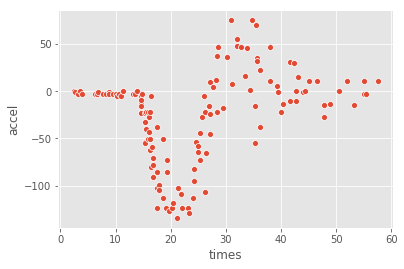

In [2]:
X = pd.read_csv('../dataset/mcycle.csv')
sns.scatterplot(X['times'], X['accel'])
N = len(X)
x_motor = X['times']
y_motor = X['accel']
x_motor = scaler(x_motor)
y_motor = scaler(y_motor)
knn = KNeighborsRegressor(n_neighbors=3) # tune k?
Y_ = knn.fit(x_motor.reshape(-1,1), y_motor.reshape(-1,1)).predict(x_motor.reshape(-1,1)).flatten()

## Linear regression with Adaptive Roust loss

0   : loss=2.155881  alpha=1.997990  scale=1.006333
500 : loss=1.372991  alpha=1.998198  scale=0.952053
1000: loss=1.372988  alpha=1.998368  scale=0.952300
1500: loss=1.372985  alpha=1.998518  scale=0.952522
2000: loss=1.372983  alpha=1.998639  scale=0.952702
2500: loss=1.372982  alpha=1.998730  scale=0.952840
3000: loss=1.372981  alpha=1.998796  scale=0.952940
3500: loss=1.372980  alpha=1.998846  scale=0.953016
4000: loss=1.372979  alpha=1.998883  scale=0.953074
4500: loss=1.372979  alpha=1.998911  scale=0.953117
MSE: 0.912145


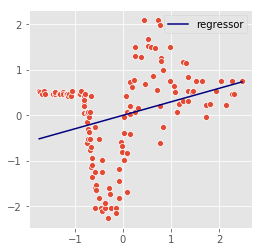

In [3]:
# Fit a linear regression, and the parameters of an adaptive loss.
regression = RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu', alpha_init=1.998)
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 
x = torch.Tensor(x_motor)
y = torch.Tensor(y_motor)

hetero_alpha = []
hetero_scale = []
for epoch in range(5000): 

    y_i = regression(x) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 500) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 
    hetero_alpha.append(adaptive.alpha()[0,0].data.numpy())
    hetero_scale.append(adaptive.scale()[0,0].data.numpy())

# It fits!
plot_regression(regression)
regression.linear._parameters
y_hat = regression(x) 
mse = ((y_hat-y)**2).mean().detach().numpy()
print('MSE: {:02f}'.format(mse))

Text(0, 0.5, 'log alpha')

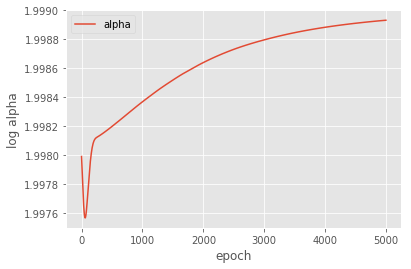

In [4]:
sns.lineplot(np.arange(len(hetero_alpha)), np.array(hetero_alpha), label="alpha")
plt.xlabel('epoch')
plt.ylabel('log alpha')

Text(0, 0.5, 'log scale parameter')

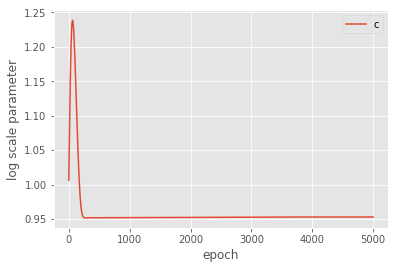

In [5]:
sns.lineplot(np.arange(len(hetero_alpha)), np.array(hetero_scale), label="c")
plt.xlabel('epoch')
plt.ylabel('log scale parameter')

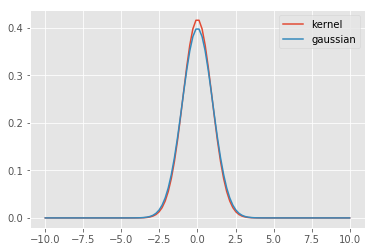

In [6]:
dist = distribution.Distribution()
alpha=hetero_alpha[-1]
scale=hetero_scale[-1]
x_range = 10
y = dist.nllfun(torch.Tensor(np.linspace(-x_range, x_range, 100)), float(alpha), float(scale)).data.numpy()
sns.lineplot(np.linspace(-x_range, x_range, 100), np.exp(-y), label='kernel')
y = dist.nllfun(torch.Tensor(np.linspace(-x_range, x_range, 100)), float(2), float(1)).data.numpy()
sns.lineplot(np.linspace(-x_range, x_range, 100), np.exp(-y), label='gaussian')

# Optimize Alpha for each data

## fit N alpha and N variance-term

In [7]:
alpha_dense = nn.Parameter(torch.Tensor([-1]*len(x_motor)))
scale_dense = nn.Parameter(torch.Tensor([0]*len(x_motor)))
optimizer = torch.optim.Adam([scale_dense, alpha_dense], lr = 1e-4) 
x = torch.Tensor(x_motor)
y = torch.Tensor(y_motor)
y_ = torch.Tensor(Y_)

for epoch in tqdm(range(15000)): 
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y - y_, alpha=torch.exp(alpha_dense), scale=torch.exp(scale_dense)))
    loss = loss + scale_dense.mean() + dist.log_base_partition_function(torch.exp(alpha_dense)).mean()
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 1000) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}'.format(epoch, loss.data))  

0   : loss=1.399151
1000: loss=1.302105
2000: loss=1.206918
3000: loss=1.113497
4000: loss=1.021830
5000: loss=0.931936
6000: loss=0.843795
7000: loss=0.757356
8000: loss=0.672553
9000: loss=0.589298
10000: loss=0.507418
11000: loss=0.426586
12000: loss=0.346219
13000: loss=0.265257
14000: loss=0.181286



In [8]:
alpha_hat_dense = torch.exp(alpha_dense).data.numpy()
scale_hat_dense = torch.exp(scale_dense).data.numpy()

Text(0.5, 0, 'times')

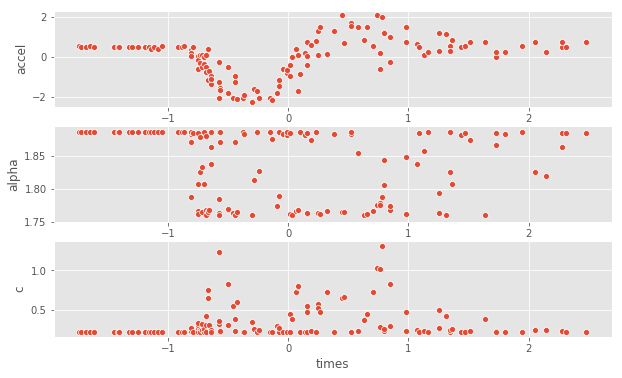

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(10,6))
sns.scatterplot(x.data.numpy(), y.data.numpy(), ax=ax[0])
ax[0].set_ylabel('accel')
sns.scatterplot(x.data.numpy(), alpha_hat_dense, ax=ax[1])
ax[1].set_ylabel('alpha')
sns.scatterplot(x.data.numpy(), scale_hat_dense, ax=ax[2])
ax[2].set_ylabel('c')
plt.xlabel('times')

## fit N alpha and 1 variance-term

In [10]:
# Fit a linear regression using mean squared error.
alpha_dense = nn.Parameter(torch.Tensor([-1]*len(x_motor)))
scale_dense = nn.Parameter(torch.Tensor([0]))
optimizer = torch.optim.Adam([scale_dense, alpha_dense], lr = 1e-4) 
x = torch.Tensor(x_motor)
y = torch.Tensor(y_motor)
y_ = torch.Tensor(Y_)
for epoch in tqdm(range(15000)): 

    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y - y_, alpha=torch.exp(alpha_dense), scale=torch.exp(scale_dense)))
    loss = loss + scale_dense.mean() + dist.log_base_partition_function(torch.exp(alpha_dense)).mean()

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 1000) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}'.format(epoch, loss.data))  
alpha_hat_dense = torch.exp(alpha_dense).data.numpy()
scale_hat_dense = torch.exp(scale_dense).data.numpy()

0   : loss=1.399151
1000: loss=1.302361
2000: loss=1.207913
3000: loss=1.115960
4000: loss=1.026733
5000: loss=0.940538
6000: loss=0.857698
7000: loss=0.778503
8000: loss=0.703327
9000: loss=0.632523
10000: loss=0.566193
11000: loss=0.504056
12000: loss=0.445880
13000: loss=0.391025
14000: loss=0.337427



Text(0.5, 0, 'times')

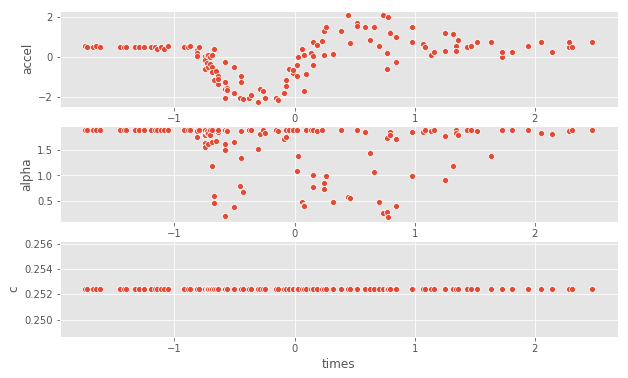

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(10,6))
sns.scatterplot(x.data.numpy(), y.data.numpy(), ax=ax[0])
ax[0].set_ylabel('accel')
sns.scatterplot(x.data.numpy(), alpha_hat_dense, ax=ax[1])
ax[1].set_ylabel('alpha')
sns.scatterplot(x.data.numpy(), np.repeat(scale_hat_dense, len(x)), ax=ax[2])
ax[2].set_ylabel('c')
plt.xlabel('times')

## fit 1 alpha and N variance-term

In [12]:
# Fit a linear regression using mean squared error.
alpha_dense = nn.Parameter(torch.Tensor([-1]))
scale_dense = nn.Parameter(torch.Tensor([0]*len(x_motor))) 
optimizer = torch.optim.Adam([scale_dense, alpha_dense], lr = 1e-4) 

x = torch.Tensor(x_motor)
y = torch.Tensor(y_motor)
y_ = torch.Tensor(Y_)

for epoch in tqdm(range(15000)): 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y - y_, alpha=torch.exp(alpha_dense), scale=torch.exp(scale_dense)))
    loss = loss + scale_dense.mean() + dist.log_base_partition_function(torch.exp(alpha_dense)).mean()

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 1000) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}'.format(epoch, loss.data))  

alpha_hat_dense = torch.exp(alpha_dense).data.numpy()
scale_hat_dense = torch.exp(scale_dense).data.numpy()

0   : loss=1.399151
1000: loss=1.302105
2000: loss=1.206917
3000: loss=1.113497
4000: loss=1.021832
5000: loss=0.931940
6000: loss=0.843804
7000: loss=0.757372
8000: loss=0.672580
9000: loss=0.589344
10000: loss=0.507495
11000: loss=0.426717
12000: loss=0.346450
13000: loss=0.265706
14000: loss=0.182333



Text(0.5, 0, 'times')

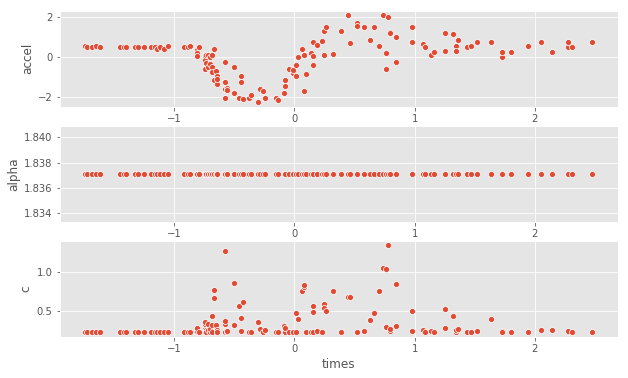

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(10,6))
sns.scatterplot(x.data.numpy(), y.data.numpy(), ax=ax[0])
ax[0].set_ylabel('accel')
sns.scatterplot(x.data.numpy(), np.repeat(alpha_hat_dense, len(x)), ax=ax[1])
ax[1].set_ylabel('alpha')
sns.scatterplot(x.data.numpy(), scale_hat_dense, ax=ax[2])
ax[2].set_ylabel('c')
plt.xlabel('times')